# Детекция

In [1]:
!rm -r runs/

rm: cannot remove 'runs/': No such file or directory


In [2]:
import os
from google.colab import userdata

import locale
import numpy as np
import pandas as pd


os.environ["ROBOFLOW_API_KEY"] = "vg8v4MUvXtqibFqEEQSb" # чтобы скачать dataset

os.chdir("/content")
HOME = os.getcwd()

!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn # YOLO скачать бесплатно
!pip install -q git+https://github.com/ultralytics/ultralytics.git

import cv2
from ultralytics import YOLO # YOLO
import supervision as sv
from roboflow import download_dataset # чтобы скачать dataset
from supervision.metrics import MeanAveragePrecision

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 36.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
dataset = download_dataset('https://universe.roboflow.com/roboflow-100/poker-cards-cxcvz/dataset/2', 'yolov8')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to poker-cards-2 in yolov8:: 100%|██████████| 2582/2582 [00:00<00:00, 2748.91it/s]


In [ ]:
# перезаписывем конфигурационнай файл в формате для YOLO
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [ ]:
models = ["yolo12n.yaml", 'yolo11n.yaml', 'yolov10n.yaml', "yolov9m.yaml", 'yolov8n.yaml'] # имена моделей для сравнения метрик
data = pd.DataFrame()
for i in range(len(models)):
  # выбираем модель
  model_name = models[i]
  model = YOLO(model_name)
  # train
  results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)
  locale.getpreferredencoding = lambda: "UTF-8"
  # test
  ds = sv.DetectionDataset.from_yolo(
      images_directory_path=f"{dataset.location}/test/images",
      annotations_directory_path=f"{dataset.location}/test/labels",
      data_yaml_path=f"{dataset.location}/data.yaml"
  )
  # вытаскиваем метрики и скорость
  train_dir = "train" if i == 0 else "train" + str(i+1)
  model = YOLO(f'/{HOME}/runs/detect/'+train_dir+'/weights/best.pt')

  predictions = []
  targets = []
  speeds = []

  for _, image, target in ds:
      results = model(image, verbose=False)[0]
      detections = sv.Detections.from_ultralytics(results)
      speeds.append(results.speed['inference'])

      predictions.append(detections)
      targets.append(target)

  map = MeanAveragePrecision().update(predictions, targets).compute()
  speed = np.array(speeds).mean()
  # смотрим метрики и скорость
  print(models[i] + ":")
  print("\tmAP 50:95 ", map.map50_95)
  print("\tmAP 50 ", map.map50)
  print("\tmAP 75 ", map.map75)
  print("\tSpeed ", speed)
  new_row = pd.DataFrame({"Name": [models[i]], "mAP 50:95": [map.map50_95], \
                          "mAP 50": [map.map50], "mAP 75": [map.map75], \
                          "Speed ": [speed]})
  data = pd.concat([data, new_row], ignore_index=True)

Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.yaml, data=/content/poker-cards-2/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, l

100%|██████████| 755k/755k [00:00<00:00, 18.9MB/s]


Overriding model.yaml nc=80 with nc=53

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 89.2MB/s]


AMP: checks passed ✅


train: Scanning /content/poker-cards-2/train/labels... 964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 964/964 [00:00<00:00, 1936.12it/s]


train: New cache created: /content/poker-cards-2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/poker-cards-2/valid/labels... 193 images, 0 backgrounds, 0 corrupt: 100%|██████████| 193/193 [00:00<00:00, 1481.22it/s]

val: New cache created: /content/poker-cards-2/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000175, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.15G      5.476      12.38      8.674         31        640: 100%|██████████| 61/61 [00:23<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]

                   all        193        838          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.45G      5.422      12.23      8.327         22        640: 100%|██████████| 61/61 [00:21<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]

                   all        193        838          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.48G      5.311      11.99      7.956         33        640: 100%|██████████| 61/61 [00:21<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]

                   all        193        838          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.48G      5.254      11.76      7.527         28        640: 100%|██████████| 61/61 [00:21<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]


                   all        193        838     0.0104     0.0049    0.00593    0.00225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.51G      5.017      11.42      7.079         47        640: 100%|██████████| 61/61 [00:20<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]


                   all        193        838    0.00335     0.0209    0.00286   0.000754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.53G      4.932      11.14      6.717         39        640: 100%|██████████| 61/61 [00:20<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


                   all        193        838    0.00512      0.105    0.00641    0.00246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.54G      4.692      10.81      6.331         37        640: 100%|██████████| 61/61 [00:20<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]


                   all        193        838    0.00475      0.155    0.00682     0.0024

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.55G      4.375      10.49      5.953         25        640: 100%|██████████| 61/61 [00:21<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


                   all        193        838    0.00504      0.177    0.00991    0.00306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.57G      4.057      10.15       5.55         36        640: 100%|██████████| 61/61 [00:21<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]


                   all        193        838    0.00604      0.233     0.0152    0.00687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.59G       3.83      9.789      5.242         37        640: 100%|██████████| 61/61 [00:21<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


                   all        193        838    0.00734      0.228     0.0232     0.0102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.61G      3.676      9.559      5.021         26        640: 100%|██████████| 61/61 [00:20<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.88it/s]

                   all        193        838    0.00674       0.35     0.0226     0.0121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.61G      3.487       9.29      4.813         41        640: 100%|██████████| 61/61 [00:20<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]


                   all        193        838    0.00927      0.272     0.0261     0.0145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.64G      3.333      9.064      4.602         48        640: 100%|██████████| 61/61 [00:21<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]


                   all        193        838     0.0104      0.405     0.0306      0.019

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.65G      3.163      8.806      4.413         39        640: 100%|██████████| 61/61 [00:21<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]


                   all        193        838     0.0113      0.509     0.0349     0.0219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.67G      3.143      8.682      4.353         56        640: 100%|██████████| 61/61 [00:21<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]


                   all        193        838      0.192     0.0551     0.0431     0.0292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.67G      3.045      8.439      4.234         31        640: 100%|██████████| 61/61 [00:21<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]


                   all        193        838      0.222     0.0597     0.0465      0.029

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       3.7G      2.964      8.254       4.11         32        640: 100%|██████████| 61/61 [00:20<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]


                   all        193        838      0.155     0.0707     0.0527     0.0363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.71G      2.871      8.067       4.02         45        640: 100%|██████████| 61/61 [00:19<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]


                   all        193        838      0.348     0.0608     0.0645     0.0443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.73G      2.845      7.896      3.948         40        640: 100%|██████████| 61/61 [00:21<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]


                   all        193        838      0.249     0.0677     0.0751     0.0526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.74G      2.832      7.811       3.91         27        640: 100%|██████████| 61/61 [00:21<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.28it/s]


                   all        193        838      0.158     0.0984     0.0835     0.0585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.76G      2.753      7.596       3.83         42        640: 100%|██████████| 61/61 [00:21<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]


                   all        193        838      0.107      0.129     0.0835     0.0602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.78G      2.721      7.516      3.798         33        640: 100%|██████████| 61/61 [00:20<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


                   all        193        838      0.166      0.141      0.101      0.075

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.79G      2.677      7.358      3.745         52        640: 100%|██████████| 61/61 [00:20<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]


                   all        193        838      0.152      0.168      0.105     0.0785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       3.8G      2.638       7.21      3.685         33        640: 100%|██████████| 61/61 [00:20<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]


                   all        193        838      0.139       0.17      0.113     0.0863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.83G      2.619      7.091       3.64         26        640: 100%|██████████| 61/61 [00:21<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]


                   all        193        838      0.159      0.198      0.124     0.0966

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.84G      2.584      6.996      3.636         30        640: 100%|██████████| 61/61 [00:21<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]


                   all        193        838      0.181      0.187      0.123      0.096

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.86G      2.564      6.945      3.586         39        640: 100%|██████████| 61/61 [00:21<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.37it/s]


                   all        193        838      0.159      0.208      0.138      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.86G      2.523      6.797      3.526         38        640: 100%|██████████| 61/61 [00:21<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]


                   all        193        838      0.136      0.221      0.141      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.89G      2.494      6.657      3.483         49        640: 100%|██████████| 61/61 [00:20<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]

                   all        193        838      0.143      0.257      0.153       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       3.9G      2.468      6.591      3.441         38        640: 100%|██████████| 61/61 [00:20<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]


                   all        193        838      0.157      0.254      0.147      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.92G      2.452      6.569      3.441         28        640: 100%|██████████| 61/61 [00:21<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]


                   all        193        838      0.155      0.262      0.157      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.92G      2.439      6.488      3.439         38        640: 100%|██████████| 61/61 [00:21<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]


                   all        193        838      0.161      0.248      0.166      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.95G      2.401      6.345      3.382         45        640: 100%|██████████| 61/61 [00:21<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]


                   all        193        838      0.173      0.296      0.167      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.97G       2.37      6.257      3.332         45        640: 100%|██████████| 61/61 [00:21<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]


                   all        193        838      0.154      0.275      0.174       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.98G      2.347      6.251      3.321         46        640: 100%|██████████| 61/61 [00:20<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


                   all        193        838      0.174      0.311      0.181      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.99G      2.344      6.186      3.327         23        640: 100%|██████████| 61/61 [00:20<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]


                   all        193        838      0.175      0.276      0.178      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.01G       2.34      6.102      3.295         30        640: 100%|██████████| 61/61 [00:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]


                   all        193        838      0.171      0.309      0.185      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.03G      2.315      6.077      3.266         40        640: 100%|██████████| 61/61 [00:21<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]


                   all        193        838      0.181      0.326      0.197      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.04G      2.316      5.978      3.258         42        640: 100%|██████████| 61/61 [00:21<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]


                   all        193        838       0.17      0.329      0.191      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.05G      2.283      5.993      3.242         51        640: 100%|██████████| 61/61 [00:21<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]


                   all        193        838      0.175      0.365      0.195      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.07G      2.267      5.937      3.247         29        640: 100%|██████████| 61/61 [00:21<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]


                   all        193        838      0.192      0.335      0.206      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.09G      2.215      5.785      3.173         34        640: 100%|██████████| 61/61 [00:20<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]


                   all        193        838      0.185      0.341       0.21      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.11G      2.195      5.757      3.159         20        640: 100%|██████████| 61/61 [00:20<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.26it/s]


                   all        193        838      0.189      0.375      0.224      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.11G      2.228      5.752      3.188         32        640: 100%|██████████| 61/61 [00:20<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]


                   all        193        838      0.199      0.353      0.222       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.14G      2.201      5.668      3.141         32        640: 100%|██████████| 61/61 [00:21<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]


                   all        193        838      0.181      0.395      0.232       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.15G      2.186      5.605      3.132         33        640: 100%|██████████| 61/61 [00:21<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


                   all        193        838      0.191      0.394      0.235      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.17G      2.175      5.602      3.113         44        640: 100%|██████████| 61/61 [00:22<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]


                   all        193        838      0.198       0.39      0.236       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.17G      2.134       5.53      3.081         27        640: 100%|██████████| 61/61 [00:21<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]


                   all        193        838      0.201      0.408      0.243      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       4.2G      2.151       5.52      3.125         43        640: 100%|██████████| 61/61 [00:20<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


                   all        193        838      0.218      0.398      0.251      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.21G      2.152      5.474      3.086         56        640: 100%|██████████| 61/61 [00:20<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]


                   all        193        838        0.2      0.397      0.252      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.23G      2.142      5.444       3.07         47        640: 100%|██████████| 61/61 [00:21<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]


                   all        193        838      0.205      0.424      0.265      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.24G      2.156      5.454        3.1         40        640: 100%|██████████| 61/61 [00:21<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]


                   all        193        838      0.231       0.46      0.268      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.26G      2.131      5.426      3.091         38        640: 100%|██████████| 61/61 [00:21<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]


                   all        193        838      0.228      0.449      0.274      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.28G       2.09      5.303      3.034         36        640: 100%|██████████| 61/61 [00:21<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]


                   all        193        838      0.223       0.45      0.279      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.29G      2.128      5.372      3.079         54        640: 100%|██████████| 61/61 [00:21<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        193        838      0.222      0.467      0.287      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       4.3G      2.092      5.283      3.034         29        640: 100%|██████████| 61/61 [00:20<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


                   all        193        838      0.226      0.446      0.281      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.33G      2.105      5.244      3.024         33        640: 100%|██████████| 61/61 [00:20<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]


                   all        193        838      0.234      0.448       0.29       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.35G      2.106       5.26      3.059         23        640: 100%|██████████| 61/61 [00:21<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]


                   all        193        838      0.241      0.458      0.298      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.36G      2.078      5.192      3.015         34        640: 100%|██████████| 61/61 [00:21<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]


                   all        193        838      0.248      0.471      0.299       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.36G      2.089      5.255      3.037         35        640: 100%|██████████| 61/61 [00:21<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]


                   all        193        838      0.231      0.445      0.304      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.39G       2.07      5.151      3.018         26        640: 100%|██████████| 61/61 [00:20<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


                   all        193        838      0.246      0.463      0.307      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       4.4G      2.048      5.148      2.993         51        640: 100%|██████████| 61/61 [00:20<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]


                   all        193        838      0.259      0.485      0.319      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.42G       2.02       5.07      2.967         21        640: 100%|██████████| 61/61 [00:21<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]


                   all        193        838      0.275      0.437      0.317      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.42G      2.037      5.044      2.987         41        640: 100%|██████████| 61/61 [00:21<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]


                   all        193        838      0.271      0.455      0.308      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.45G      2.004      4.976      2.935         23        640: 100%|██████████| 61/61 [00:21<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]


                   all        193        838      0.247      0.473      0.325      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.46G      2.016      5.046      2.974         28        640: 100%|██████████| 61/61 [00:21<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]


                   all        193        838      0.283      0.462      0.336      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.48G      1.999      4.949      2.952         41        640: 100%|██████████| 61/61 [00:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


                   all        193        838      0.268      0.492      0.334       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.49G      2.008      5.003      2.984         30        640: 100%|██████████| 61/61 [00:20<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


                   all        193        838       0.28       0.48      0.334      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.51G      2.022      4.949      2.949         49        640: 100%|██████████| 61/61 [00:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]


                   all        193        838      0.283      0.468       0.34      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.53G      2.021      4.926      2.956         35        640: 100%|██████████| 61/61 [00:21<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]


                   all        193        838      0.275      0.493      0.339      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.54G      2.018      4.919      2.957         24        640: 100%|██████████| 61/61 [00:21<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


                   all        193        838      0.282      0.496      0.353      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.55G      1.965      4.887      2.926         29        640: 100%|██████████| 61/61 [00:21<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]


                   all        193        838      0.276      0.497      0.344      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.57G      2.006      4.879      2.947         36        640: 100%|██████████| 61/61 [00:21<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


                   all        193        838      0.285      0.489      0.356      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.59G      1.961      4.794      2.899         32        640: 100%|██████████| 61/61 [00:20<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


                   all        193        838       0.29      0.496      0.369       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.61G      1.933       4.77      2.884         28        640: 100%|██████████| 61/61 [00:20<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]


                   all        193        838      0.294      0.489      0.353      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.61G      1.991      4.832      2.927         24        640: 100%|██████████| 61/61 [00:21<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]


                   all        193        838      0.303      0.481      0.369      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.64G      1.971      4.792      2.899         37        640: 100%|██████████| 61/61 [00:21<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]


                   all        193        838      0.294      0.516      0.369       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.65G      1.945      4.738      2.885         35        640: 100%|██████████| 61/61 [00:21<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]


                   all        193        838        0.3      0.481      0.372      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.67G      1.924      4.761      2.884         23        640: 100%|██████████| 61/61 [00:21<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]


                   all        193        838      0.295      0.517      0.366      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.67G      2.002      4.817      2.953         31        640: 100%|██████████| 61/61 [00:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


                   all        193        838        0.3      0.508      0.376      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       4.7G      1.919      4.746      2.887         25        640: 100%|██████████| 61/61 [00:20<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]


                   all        193        838      0.309      0.508      0.377      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.71G      1.925       4.67      2.861         37        640: 100%|██████████| 61/61 [00:21<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]


                   all        193        838      0.316      0.499      0.383      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.73G      1.969      4.742      2.914         43        640: 100%|██████████| 61/61 [00:21<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]


                   all        193        838      0.306      0.516      0.375      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.73G      1.929      4.668      2.882         31        640: 100%|██████████| 61/61 [00:21<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]


                   all        193        838      0.304      0.524      0.387      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.76G      1.916      4.663      2.877         31        640: 100%|██████████| 61/61 [00:21<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]


                   all        193        838      0.305      0.538       0.39      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.78G      1.932      4.662      2.868         34        640: 100%|██████████| 61/61 [00:20<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]


                   all        193        838      0.316       0.53      0.393      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.79G      1.939      4.665      2.885         42        640: 100%|██████████| 61/61 [00:20<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]


                   all        193        838      0.319      0.525      0.389      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       4.8G      1.927      4.634      2.879         42        640: 100%|██████████| 61/61 [00:20<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]


                   all        193        838      0.326      0.535      0.397      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.82G       1.92      4.623       2.87         45        640: 100%|██████████| 61/61 [00:21<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.35it/s]


                   all        193        838       0.32      0.517      0.404      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.84G      1.916       4.59       2.86         38        640: 100%|██████████| 61/61 [00:21<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]


                   all        193        838      0.322      0.529        0.4       0.34
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.86G      1.655       4.56      2.747         16        640: 100%|██████████| 61/61 [00:22<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]


                   all        193        838       0.31      0.523      0.396      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.86G      1.633      4.495      2.758         19        640: 100%|██████████| 61/61 [00:20<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


                   all        193        838      0.313      0.527      0.395      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.89G      1.606      4.386      2.727         17        640: 100%|██████████| 61/61 [00:19<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]


                   all        193        838      0.315      0.519      0.396      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       4.9G      1.591      4.348      2.726         16        640: 100%|██████████| 61/61 [00:20<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]


                   all        193        838      0.332      0.523      0.394      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.92G      1.595      4.349      2.717         18        640: 100%|██████████| 61/61 [00:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]


                   all        193        838      0.343       0.49      0.401      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.93G       1.59      4.326      2.726         16        640: 100%|██████████| 61/61 [00:20<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]


                   all        193        838      0.322      0.534      0.407      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.95G      1.576      4.255       2.74         17        640: 100%|██████████| 61/61 [00:19<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]


                   all        193        838      0.321      0.526      0.407      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.97G      1.559      4.216      2.672         17        640: 100%|██████████| 61/61 [00:20<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]


                   all        193        838      0.325      0.521      0.406      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.98G      1.602      4.288      2.735         17        640: 100%|██████████| 61/61 [00:20<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]

                   all        193        838      0.328      0.508       0.41      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.99G      1.568      4.247      2.722         18        640: 100%|██████████| 61/61 [00:20<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]

                   all        193        838      0.313      0.542       0.41       0.35



100 epochs completed in 0.671 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.8MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.8MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 125 layers, 2,715,086 parameters, 0 gradients, 8.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


                   all        193        838      0.326       0.51      0.411       0.35
           10 Diamonds         17         17      0.404      0.765      0.466       0.39
             10 Hearts         15         15      0.323      0.573      0.383      0.331
             10 Spades         18         18       0.42      0.778      0.612      0.498
           10 Trefoils         16         16      0.241      0.312      0.243      0.217
            2 Diamonds         17         17      0.165       0.21      0.262      0.209
              2 Hearts         15         15      0.436        0.8      0.511      0.406
              2 Spades         18         18      0.325      0.444      0.314      0.261
            2 Trefoils         16         16      0.298      0.347      0.355      0.332
            3 Diamonds         17         17      0.374      0.493      0.422      0.364
              3 Hearts         15         15      0.313      0.533      0.399      0.325
              3 Spade

train: Scanning /content/poker-cards-2/train/labels.cache... 964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 964/964 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/poker-cards-2/valid/labels.cache... 193 images, 0 backgrounds, 0 corrupt: 100%|██████████| 193/193 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000175, momentum=0.9) with parameter groups 149 weight(decay=0.0), 156 weight(decay=0.0005), 155 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.45G      2.905      5.491       4.24         31        640: 100%|██████████| 61/61 [00:44<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]

                   all        193        838          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.03G      2.868      5.306      4.073         22        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        193        838          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      9.03G      2.776      4.765      3.745         33        640: 100%|██████████| 61/61 [00:40<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


                   all        193        838     0.0123      0.212      0.015    0.00589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      9.03G      2.616      4.195      3.409         28        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


                   all        193        838      0.218      0.125     0.0491     0.0212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.03G       2.28       3.68      3.056         47        640: 100%|██████████| 61/61 [00:40<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


                   all        193        838      0.109       0.19     0.0965     0.0561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      9.03G      2.007      3.426      2.763         39        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


                   all        193        838      0.274      0.172      0.155     0.0915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      9.03G      1.804      3.162      2.541         37        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all        193        838      0.211      0.461      0.254      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.03G      1.637      2.946      2.367         25        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]

                   all        193        838      0.288      0.404      0.291      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.03G      1.481      2.758      2.214         36        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


                   all        193        838      0.257      0.459      0.319      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.03G      1.394      2.615      2.095         37        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


                   all        193        838      0.355      0.593      0.393      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.03G      1.318      2.539      2.008         26        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]

                   all        193        838       0.32      0.616      0.438      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.03G      1.233      2.402      1.915         41        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

                   all        193        838      0.309      0.581      0.435      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.03G      1.193      2.335      1.871         48        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

                   all        193        838      0.321      0.602      0.446      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.03G      1.134      2.244       1.81         39        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]

                   all        193        838      0.461      0.586      0.551      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.03G      1.133      2.171      1.784         56        640: 100%|██████████| 61/61 [00:40<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        193        838      0.448       0.72      0.594       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.03G      1.068      2.077      1.725         31        640: 100%|██████████| 61/61 [00:40<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        193        838      0.454      0.687      0.606      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.03G      1.039      2.016      1.678         32        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        193        838      0.509      0.724      0.644      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      9.03G     0.9979      1.932      1.648         45        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        193        838      0.452      0.705      0.646      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.03G     0.9791      1.877      1.619         40        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


                   all        193        838      0.509      0.786      0.699      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.03G     0.9775      1.828       1.61         27        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

                   all        193        838      0.579      0.681      0.709      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      9.03G     0.9326      1.736      1.558         42        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        193        838      0.618      0.807      0.798      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.03G     0.9297      1.708      1.554         33        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        193        838      0.588      0.791      0.777       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.03G     0.9179      1.633       1.55         52        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        193        838      0.695      0.804       0.84      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      9.03G     0.8968      1.569      1.522         33        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]

                   all        193        838      0.711      0.737      0.815      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      9.03G     0.8678      1.528      1.489         26        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        193        838      0.692      0.805      0.846       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      9.03G     0.8617      1.487       1.49         30        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        193        838      0.796      0.773      0.879      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      9.03G     0.8716      1.453      1.488         39        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        193        838      0.761      0.809      0.899      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      9.03G     0.8408      1.382      1.457         38        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        193        838      0.847      0.838      0.913      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      9.03G      0.816      1.318      1.425         49        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


                   all        193        838      0.823      0.819      0.915      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      9.03G     0.8178      1.343      1.422         38        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


                   all        193        838      0.854      0.809       0.93      0.816

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      9.03G     0.8183      1.325      1.426         28        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        193        838      0.799      0.802      0.906      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      9.03G     0.7974      1.279      1.409         38        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        193        838       0.88      0.879      0.953       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      9.03G     0.7892      1.224      1.397         45        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        193        838      0.894      0.871       0.95      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      9.03G     0.7807      1.157      1.385         45        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        193        838      0.914      0.901      0.967      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      9.03G     0.7744      1.171      1.377         46        640: 100%|██████████| 61/61 [00:40<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        193        838      0.829      0.861      0.933      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      9.03G     0.7556      1.145      1.357         23        640: 100%|██████████| 61/61 [00:40<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        193        838      0.917      0.881      0.962      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      9.03G       0.75      1.096      1.358         30        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        193        838      0.916      0.898      0.971      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      9.03G     0.7657      1.103      1.358         40        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        193        838      0.844      0.817      0.905      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      9.03G     0.7487      1.078      1.352         42        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


                   all        193        838      0.924      0.894      0.968      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      9.03G     0.7445      1.069      1.349         51        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


                   all        193        838      0.907      0.903      0.967      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      9.03G     0.7414      1.057      1.346         29        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        193        838      0.903       0.89      0.961      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      9.03G     0.7214     0.9984      1.319         34        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        193        838      0.945       0.93      0.979      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      9.03G      0.718     0.9973      1.321         20        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

                   all        193        838      0.935      0.928      0.977      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      9.03G     0.7165     0.9825      1.321         32        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


                   all        193        838      0.954      0.906      0.969      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      9.03G     0.7027     0.9424      1.307         32        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        193        838      0.953      0.928      0.977      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      9.03G      0.694     0.9365        1.3         33        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        193        838      0.935       0.93      0.979      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      9.03G     0.6926     0.9389      1.292         44        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        193        838       0.95      0.931       0.98      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      9.03G     0.6887     0.9002      1.286         27        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        193        838      0.942      0.939      0.977      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      9.03G     0.6883     0.9016      1.293         43        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        193        838      0.959      0.937      0.982      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      9.03G     0.6783     0.8798      1.272         56        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        193        838      0.943      0.935      0.981      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      9.03G     0.6865     0.8849      1.284         47        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        193        838      0.932      0.937      0.978       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      9.03G     0.6824     0.8884      1.281         40        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


                   all        193        838      0.957      0.934      0.982      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      9.03G     0.6781     0.8768      1.279         38        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


                   all        193        838      0.948      0.945      0.982      0.878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      9.03G     0.6612     0.8354      1.258         36        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        193        838      0.942      0.938      0.981      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      9.03G     0.6801     0.8651      1.278         54        640: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        193        838      0.922      0.935      0.979      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      9.03G     0.6599      0.848      1.258         29        640: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        193        838      0.951      0.943      0.982      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      9.03G     0.6642     0.8209      1.259        139        640:  98%|█████████▊| 60/61 [00:39<00:00,  1.48it/s]

In [ ]:
data

,Name,mAP 50:95,mAP 50,mAP 75,Speed
0,yolo12n.yaml,0.353123,0.418922,0.410253,16.104419
1,yolo11.yaml,0.373519,0.442529,0.428105,9.058706


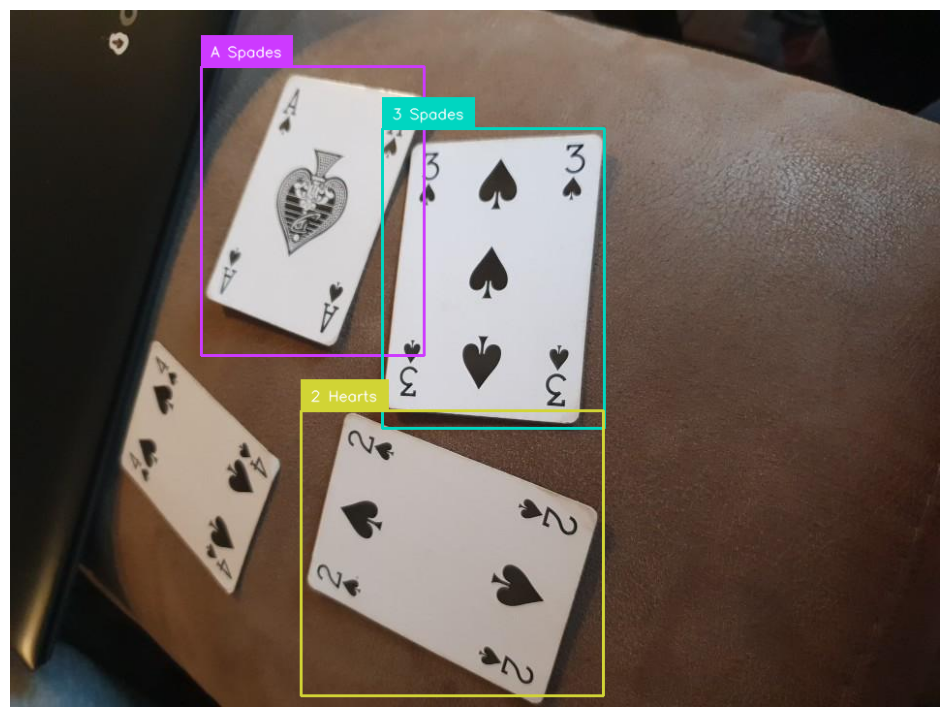

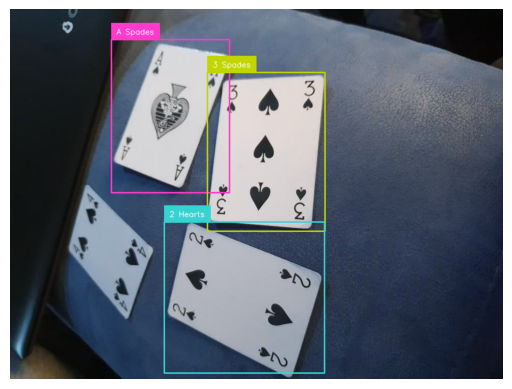

In [ ]:
# смотрим картинку yolo12
import matplotlib.pyplot as plt

i = 30

image_path, image, target = ds[i]

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')
results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

#sv.plot_image(annotated_image)
plt.dpi = 600
plt.imshow(annotated_image)
plt.axis('off')
plt.savefig("detect")
#plt.close()

# Сегментация

In [3]:
dataset = download_dataset('https://universe.roboflow.com/penguins471/penguin-finder-seg/dataset/4', 'yolov9')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to penguin-finder-seg-4 in yolov9:: 100%|██████████| 1140/1140 [00:00<00:00, 3220.65it/s]


In [4]:
# перезаписывем конфигурационнай файл в формате для YOLO
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [5]:
models = ['yolo12n-seg.yaml', "yolo11-seg.yaml", 'yolov9c-seg.yaml', 'yolov8n-seg.yaml'] # имена моделей для сравнения метрик
data = pd.DataFrame()
for i in range(len(models)):
  # выбираем модель
  model_name = models[i]
  model = YOLO(model_name)
  # train
  results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)
  locale.getpreferredencoding = lambda: "UTF-8"
  # test
  ds = sv.DetectionDataset.from_yolo(
      images_directory_path=f"{dataset.location}/test/images",
      annotations_directory_path=f"{dataset.location}/test/labels",
      data_yaml_path=f"{dataset.location}/data.yaml"
  )
  # вытаскиваем метрики и скорость
  train_dir = "train" if i == 0 else "train" + str(i+1)
  model = YOLO(f'/{HOME}/runs/segment/'+train_dir+'/weights/best.pt')

  speeds = []

  for _, image, target in ds:
      results = model(image, verbose=False)[0]
      speeds.append(results.speed['inference'])

  speed = np.array(speeds).mean()
  metrics = model.val()
  # смотрим метрики и скорость
  print(models[i] + ":")
  print("\tmAP 50:95(Mask) ", metrics.seg.map)
  print("\tmAP 50:95(Box) ", metrics.box.map)
  print("\tSpeed ", speed)
  new_row = pd.DataFrame({"Name": [models[i]], "mAP 50:95(Mask)": [metrics.seg.map], \
                          "mAP 50:95(Box)": [metrics.box.map], "Speed ": [speed]})
  data = pd.concat([data, new_row], ignore_index=True)

Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.yaml, data=/content/penguin-finder-seg-4/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

100%|██████████| 755k/755k [00:00<00:00, 18.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 96.0MB/s]


AMP: checks passed ✅


train: Scanning /content/penguin-finder-seg-4/train/labels... 391 images, 0 backgrounds, 0 corrupt: 100%|██████████| 391/391 [00:00<00:00, 1159.63it/s]

train: New cache created: /content/penguin-finder-seg-4/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/penguin-finder-seg-4/valid/labels... 114 images, 0 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 1071.09it/s]

val: New cache created: /content/penguin-finder-seg-4/valid/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.83G      3.775       9.75      3.499      4.217         64        640: 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        114        441     0.0045      0.349    0.00761    0.00233    0.00105     0.0816    0.00124   0.000273



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.45G      3.561      5.062      3.248      4.026         50        640: 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        114        441    0.00494      0.383    0.00763    0.00271    0.00251      0.195    0.00258   0.000662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.47G      3.218      4.824       3.01      3.675         67        640: 100%|██████████| 25/25 [00:08<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        114        441    0.00423      0.308      0.007    0.00198    0.00165       0.12    0.00139   0.000302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.48G      3.024       4.69      2.909      3.419         39        640: 100%|██████████| 25/25 [00:08<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        114        441     0.0092      0.265    0.00997    0.00276    0.00275     0.0794     0.0017    0.00037



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100       3.5G      2.939       4.51      2.809      3.251         81        640: 100%|██████████| 25/25 [00:09<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        114        441       0.11       0.15     0.0565     0.0167      0.078     0.0975     0.0293    0.00608



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.53G      2.783      4.348      2.751      3.168         33        640: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        114        441      0.166      0.143     0.0808     0.0209      0.146      0.131     0.0507    0.00905



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.55G      2.754      4.305      2.712      3.095         38        640: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        114        441      0.164      0.186      0.109     0.0321     0.0983      0.104     0.0411    0.00797



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.56G      2.686      4.249      2.557      2.983         68        640: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        114        441     0.0753      0.222     0.0676     0.0232       0.12      0.093     0.0559     0.0136



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.58G      2.637       4.19      2.521      2.913         87        640: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        114        441      0.216       0.22      0.138     0.0441      0.138      0.184     0.0776     0.0188



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100       3.6G      2.593      4.011      2.456      2.829         76        640: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        114        441      0.246      0.224      0.152     0.0528        0.2      0.186      0.105     0.0318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.62G      2.491      3.991      2.422      2.758         63        640: 100%|██████████| 25/25 [00:10<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        114        441        0.3      0.261      0.202     0.0604      0.225       0.22      0.144     0.0387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.64G      2.395      3.907       2.29      2.705         37        640: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        114        441      0.387      0.322      0.284     0.0963      0.387      0.304      0.245     0.0798



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.65G       2.36      3.913      2.264      2.665         41        640: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        114        441      0.308       0.29      0.266     0.0957      0.302      0.281       0.24     0.0808



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.67G      2.331       3.77      2.201      2.606         92        640: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        114        441      0.449      0.356      0.342      0.128      0.382      0.327      0.272     0.0915



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.69G      2.252      3.756      2.133      2.571         44        640: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        114        441       0.26      0.426      0.264     0.0935      0.296      0.388      0.267     0.0932



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.71G      2.224      3.707      2.121      2.559        131        640: 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

                   all        114        441      0.224      0.302      0.165     0.0504      0.178      0.215     0.0927     0.0247



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.73G      2.174      3.664      2.087      2.512         86        640: 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        114        441      0.342      0.367      0.261     0.0897      0.306      0.281      0.205     0.0588



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.75G       2.11      3.635      2.026      2.467         50        640: 100%|██████████| 25/25 [00:09<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all        114        441      0.459      0.528      0.467       0.17      0.421      0.433      0.376      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.76G      2.031      3.571      1.968      2.392        133        640: 100%|██████████| 25/25 [00:08<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        114        441      0.527      0.454      0.475      0.202      0.511      0.413      0.421      0.153



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.78G      2.049      3.551      1.935      2.343         46        640: 100%|██████████| 25/25 [00:09<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        114        441      0.586       0.46      0.495      0.204      0.548      0.431      0.438      0.164



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100       3.8G      1.978      3.565      1.922      2.319         48        640: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        114        441      0.559      0.509      0.547      0.242      0.567      0.473      0.489      0.195



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.82G      1.908      3.574      1.879      2.223         51        640: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        114        441      0.477      0.447      0.436      0.175      0.495       0.39      0.384      0.141



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.84G       1.91      3.424      1.843      2.231         81        640: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        114        441      0.514      0.463      0.463      0.203      0.454      0.433      0.358      0.131



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.86G      1.852      3.419      1.805      2.181         47        640: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        114        441      0.595      0.519      0.542      0.231      0.598      0.476      0.488      0.209



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.87G       1.92      3.452      1.804      2.215         39        640: 100%|██████████| 25/25 [00:11<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        114        441      0.549      0.478      0.511      0.232      0.565      0.406      0.458       0.18



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.89G      1.879      3.424       1.73      2.153        108        640: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        114        441      0.538      0.431      0.481      0.196      0.551      0.433       0.46      0.189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.91G      1.827      3.357       1.74      2.133         45        640: 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        114        441      0.631       0.54      0.606      0.288      0.608       0.49      0.529      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.93G       1.82      3.268      1.718      2.113         32        640: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all        114        441      0.608      0.546      0.593      0.276      0.609      0.519      0.568      0.255



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.95G      1.794      3.165      1.667      2.088         86        640: 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]

                   all        114        441      0.638      0.519      0.542      0.235      0.585      0.447      0.466      0.201



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.97G      1.771      3.286      1.651      2.076         37        640: 100%|██████████| 25/25 [00:09<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]

                   all        114        441      0.697      0.574      0.661      0.324      0.732      0.528      0.617      0.278



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.99G       1.74      3.188      1.616      2.044         70        640: 100%|██████████| 25/25 [00:08<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

                   all        114        441      0.778       0.59      0.679      0.336       0.73      0.565       0.63      0.295



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.01G       1.72      3.103      1.613       2.01         55        640: 100%|██████████| 25/25 [00:08<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        114        441      0.625      0.575      0.612      0.267      0.629      0.578      0.608      0.292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.02G      1.724      3.213      1.616      1.994         33        640: 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        114        441      0.657      0.498      0.598      0.286      0.646      0.476       0.55      0.251



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.04G      1.671      3.178      1.587      1.973         58        640: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        114        441      0.742       0.51      0.613      0.309      0.715      0.488      0.568       0.26



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.06G      1.746      3.175      1.624      2.011         51        640: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        114        441      0.727      0.574      0.653      0.296      0.687       0.54      0.576      0.255



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.08G      1.706      3.153      1.593      1.971        118        640: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        114        441      0.707      0.578      0.643       0.32      0.706      0.553      0.608      0.297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.09G      1.732      3.075      1.583      2.006        104        640: 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        114        441      0.677      0.528      0.603      0.307      0.706      0.496      0.557      0.243



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.11G       1.66      3.139      1.559      1.939         47        640: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        114        441      0.788      0.608      0.707      0.379      0.763      0.587       0.66      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.13G      1.642      3.033      1.502      1.926         68        640: 100%|██████████| 25/25 [00:11<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        114        441      0.739       0.61        0.7      0.356      0.779      0.569      0.667      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.15G       1.62       3.02      1.474      1.904         52        640: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        114        441      0.757      0.635       0.72      0.374      0.728      0.588      0.644       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.17G      1.607      2.964      1.489      1.895         38        640: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        114        441      0.731      0.574      0.649      0.307      0.728      0.563      0.639      0.282



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.19G      1.614      2.968      1.451      1.878         46        640: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        114        441      0.742      0.633      0.723      0.386      0.718      0.599      0.662      0.323



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.21G      1.571      2.943      1.439      1.854         57        640: 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

                   all        114        441      0.772      0.623       0.72        0.4      0.758      0.589       0.66       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.23G      1.538      2.876      1.428      1.853         57        640: 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        114        441      0.804      0.613      0.731      0.386      0.762      0.601      0.679      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.24G      1.583       2.87      1.404      1.832         51        640: 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        114        441      0.716      0.567      0.669      0.352      0.758      0.492      0.609      0.312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.26G      1.546      2.894      1.368      1.781         61        640: 100%|██████████| 25/25 [00:09<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        114        441      0.775      0.642      0.748      0.409      0.775      0.592      0.694      0.379



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.28G      1.516      2.819      1.406      1.794         74        640: 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        114        441      0.785      0.644      0.745      0.411      0.777      0.612        0.7      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100       4.3G      1.535      2.831       1.38      1.798        110        640: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        114        441       0.79      0.622      0.733      0.403      0.791       0.59      0.691      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.32G      1.525      2.872      1.394      1.806         77        640: 100%|██████████| 25/25 [00:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        114        441      0.828      0.624      0.754      0.398      0.828      0.624      0.733      0.394



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.34G      1.551      2.876      1.405      1.792         92        640: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        114        441      0.832      0.671      0.779      0.437       0.81      0.642      0.733      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.36G      1.498      2.744      1.374       1.77         86        640: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        114        441      0.831      0.615       0.76      0.414      0.767      0.637      0.722      0.394



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.38G        1.5      2.734      1.378      1.783         50        640: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        114        441      0.762      0.671      0.772       0.42      0.755      0.657      0.745      0.396



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.39G      1.473      2.795      1.334      1.737        127        640: 100%|██████████| 25/25 [00:11<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        114        441      0.778       0.66       0.74      0.422      0.793       0.61      0.694      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.41G      1.441      2.692      1.318      1.729         44        640: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        114        441      0.817       0.69      0.789      0.447       0.81      0.642      0.745      0.385



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.43G      1.459      2.742      1.312       1.71         85        640: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        114        441      0.806      0.728      0.794      0.454      0.807      0.698      0.768      0.418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.45G      1.451       2.67      1.305      1.702         43        640: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        114        441      0.795      0.649      0.771      0.441      0.739      0.651      0.713      0.353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.47G      1.419      2.653       1.29      1.684         38        640: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        114        441      0.807      0.672      0.771      0.438      0.816      0.615      0.712      0.382



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.48G      1.407      2.618       1.25      1.685         62        640: 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

                   all        114        441      0.874      0.689      0.808      0.482       0.85      0.667      0.769      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.51G      1.435      2.707       1.29      1.715         35        640: 100%|██████████| 25/25 [00:08<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        114        441      0.788      0.723       0.79      0.467       0.86      0.626      0.759      0.428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.52G      1.369      2.509      1.253      1.664         52        640: 100%|██████████| 25/25 [00:08<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        114        441       0.76      0.621      0.712      0.384      0.707      0.571      0.628      0.287



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.54G      1.393      2.612       1.27      1.672         90        640: 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]

                   all        114        441      0.813      0.694        0.8      0.469      0.799      0.671       0.76      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.56G      1.412      2.692      1.263      1.674         46        640: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all        114        441      0.831      0.682      0.805      0.469      0.824      0.683      0.781      0.436



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.58G      1.391      2.551      1.246      1.673         42        640: 100%|██████████| 25/25 [00:09<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all        114        441      0.779      0.705      0.799      0.445      0.772      0.698      0.781      0.449



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.59G      1.355      2.577      1.212      1.643         59        640: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        114        441      0.789       0.73      0.787       0.47      0.782      0.717      0.756      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.61G      1.341      2.484      1.208      1.644         53        640: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        114        441      0.863      0.688      0.807      0.476      0.846      0.674      0.775      0.427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.63G      1.397      2.632       1.22      1.657         64        640: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        114        441      0.811      0.723       0.81      0.489      0.844      0.709      0.787      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.65G      1.295       2.43      1.164      1.594         35        640: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all        114        441      0.861      0.669      0.802      0.484      0.861      0.661      0.771      0.442



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.67G      1.376      2.581      1.212      1.628         46        640: 100%|██████████| 25/25 [00:10<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        114        441      0.834      0.728      0.817      0.459      0.832      0.718      0.805      0.476



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.69G      1.355       2.49      1.206      1.627         56        640: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        114        441      0.829      0.685      0.798      0.486       0.82      0.671      0.766      0.438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.71G       1.29      2.465      1.142       1.58         97        640: 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        114        441      0.832      0.729      0.831      0.512      0.809       0.71      0.799      0.484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.72G        1.3      2.407      1.168      1.579         61        640: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

                   all        114        441      0.788      0.707      0.784      0.474      0.781      0.694      0.751      0.446



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.74G      1.343      2.475      1.184      1.598         40        640: 100%|██████████| 25/25 [00:08<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        114        441        0.8      0.744      0.824      0.504      0.827       0.73      0.812      0.484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.76G      1.313      2.444      1.174      1.597         45        640: 100%|██████████| 25/25 [00:08<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        114        441      0.821      0.726      0.822      0.508      0.814      0.705      0.795      0.468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.78G      1.272      2.379      1.124      1.554         52        640: 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        114        441      0.873      0.685      0.805       0.51      0.858      0.692      0.794      0.475



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100       4.8G      1.291      2.416      1.148      1.571         29        640: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        114        441      0.828      0.726      0.813      0.504      0.828      0.701      0.792      0.465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.82G      1.279      2.343      1.129      1.547         40        640: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        114        441       0.83      0.721      0.811      0.496      0.832      0.698      0.773      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.83G      1.296      2.449      1.127      1.572         37        640: 100%|██████████| 25/25 [00:10<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        114        441      0.849      0.707      0.815      0.498      0.857      0.682      0.797      0.482



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.85G      1.243      2.328      1.113      1.542         58        640: 100%|██████████| 25/25 [00:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        114        441      0.841      0.706      0.837      0.517      0.853      0.698      0.817      0.487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.87G      1.264      2.309      1.132      1.558         41        640: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        114        441      0.816      0.744      0.827      0.511      0.806      0.732      0.807      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.89G       1.23      2.283      1.105      1.538         41        640: 100%|██████████| 25/25 [00:09<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        114        441      0.846      0.735       0.83      0.522      0.835      0.712      0.805      0.476



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.91G      1.244      2.278       1.08      1.526         40        640: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        114        441       0.85      0.757      0.837      0.523      0.848      0.753      0.822      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.93G       1.24      2.302      1.084      1.512         76        640: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        114        441      0.839      0.744      0.818       0.51      0.834      0.719      0.797      0.499



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.95G      1.248       2.28      1.075      1.558         34        640: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        114        441      0.814      0.791      0.846      0.529      0.836      0.732      0.819      0.498



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.97G      1.214      2.314      1.062      1.522         56        640: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        114        441      0.845       0.73      0.841       0.54      0.892      0.692      0.811      0.509



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.98G       1.24      2.295      1.095      1.536         62        640: 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

                   all        114        441      0.852      0.759      0.835      0.528      0.849       0.73      0.811      0.495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100         5G      1.199      2.269      1.053      1.485         85        640: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all        114        441      0.842      0.751      0.844      0.531      0.837      0.755      0.833      0.513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.02G      1.204      2.284      1.072      1.497         41        640: 100%|██████████| 25/25 [00:09<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        114        441      0.861      0.748      0.845       0.53      0.871      0.737       0.82      0.493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.04G      1.205      2.264      1.047      1.494         76        640: 100%|██████████| 25/25 [00:09<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        114        441      0.849      0.746      0.838       0.54      0.849      0.738      0.824      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.05G      1.152      2.132     0.9943      1.453         62        640: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        114        441      0.851      0.744      0.838      0.544      0.846      0.739      0.823      0.516



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.08G      1.193      2.253      1.044      1.495         50        640: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        114        441      0.833      0.787      0.848      0.546      0.836      0.764       0.83      0.518


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100       5.1G      1.184      2.329      1.107      1.521         24        640: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all        114        441      0.864      0.694      0.825      0.515      0.847      0.694      0.805      0.479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.12G       1.17      2.227      1.053      1.524         20        640: 100%|██████████| 25/25 [00:08<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        114        441      0.817      0.751      0.842      0.549      0.811      0.738      0.821      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.14G      1.171      2.245      1.043      1.494         27        640: 100%|██████████| 25/25 [00:08<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        441      0.841      0.776      0.845      0.545      0.831      0.755      0.823      0.511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.16G      1.173      2.197      1.039      1.505         25        640: 100%|██████████| 25/25 [00:09<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        114        441      0.843      0.769      0.838      0.544      0.846      0.758      0.826       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.18G      1.161      2.211      1.007      1.504         24        640: 100%|██████████| 25/25 [00:07<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

                   all        114        441       0.85      0.776       0.85      0.549      0.841      0.766      0.837      0.522



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100       5.2G      1.148      2.195      1.005      1.483         17        640: 100%|██████████| 25/25 [00:08<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        114        441      0.858      0.752      0.845      0.554      0.856      0.741      0.832      0.522



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.21G      1.135      2.172      1.006      1.474         40        640: 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all        114        441       0.85       0.77       0.85      0.552      0.851      0.769      0.839      0.533



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.24G       1.13       2.17     0.9943      1.471         23        640: 100%|██████████| 25/25 [00:08<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all        114        441      0.854      0.773      0.853      0.556      0.843      0.764      0.837      0.524



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.25G      1.144      2.181       0.98      1.477         42        640: 100%|██████████| 25/25 [00:08<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all        114        441      0.872      0.759      0.851      0.564      0.866      0.747      0.839      0.539



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.27G      1.107      2.127     0.9582      1.451         46        640: 100%|██████████| 25/25 [00:08<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        114        441      0.869      0.757      0.851      0.562      0.864      0.753      0.837      0.537



100 epochs completed in 0.332 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:00<00:01,  2.01it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:01<00:01,  1.14it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


                   all        114        441      0.872      0.759      0.851      0.563      0.866      0.747      0.839       0.54
Speed: 0.3ms preprocess, 5.3ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/penguin-finder-seg-4/valid/labels.cache... 114 images, 0 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/8 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  12%|█▎        | 1/8 [00:00<00:05,  1.23it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  25%|██▌       | 2/8 [00:01<00:04,  1.20it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


                   all        114        441      0.868      0.761      0.851      0.563      0.865      0.742       0.84      0.541
Speed: 5.8ms preprocess, 9.0ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/segment/val
yolov8n-seg.yaml:
	mAP 50:95(Mask)  0.5414937423138995
	mAP 50:95(Box)  0.5625442538319833
	Speed  7.667344779655018


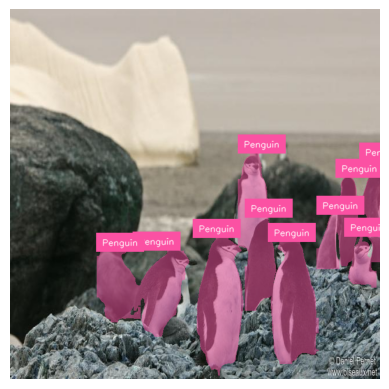

In [13]:
# смотрим картинку yolo11
import matplotlib.pyplot as plt

i = 3

image_path, image, target = ds[i]

model = YOLO(f'/{HOME}/runs/segment/train/weights/best.pt')
results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()
masks = results.masks.data

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

mask_annotator = sv.MaskAnnotator()

annotated_image = image.copy()
mask_annotator.annotate(annotated_image, detections=detections)
label_annotator.annotate(annotated_image, detections=detections)

plt.dpi = 600
plt.imshow(annotated_image)
plt.axis('off')
plt.savefig("segment")
#plt.close()

In [ ]:
data